In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from tqdm.auto import tqdm
from statsmodels.stats.anova import anova_lm

sns.set(rc={'figure.figsize':(12,8)})
plt.style.use('ggplot')

In [4]:
users = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/active_users.csv')
users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [5]:
groups = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/groups.csv')
groups

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [6]:
purchases = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/purchases.csv')
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [7]:
# Сделаем джоин 
df_purchases = purchases.merge(groups, how='left') #для каждого юзера с доходом приклеиваем его группу
df_purchases

,user_id,revenue,group
0,4412,1000.0,A
1,9000,701.0,B
2,9001,700.0,B
3,9002,702.0,B
4,5790,1002.0,B
...,...,...,...
536,5648,1908.0,B
537,2277,1912.0,B
538,5032,1911.0,B
539,908,1910.0,B


In [8]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  541 non-null    int64  
 1   revenue  541 non-null    float64
 2   group    541 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 16.9+ KB


In [9]:
(df_purchases.revenue > 0).sum()

541

In [10]:
df_purchases.isna().sum()

user_id    0
revenue    0
group      0
dtype: int64

In [11]:
df_purchases.group.value_counts()

B    434
A    107
Name: group, dtype: int64

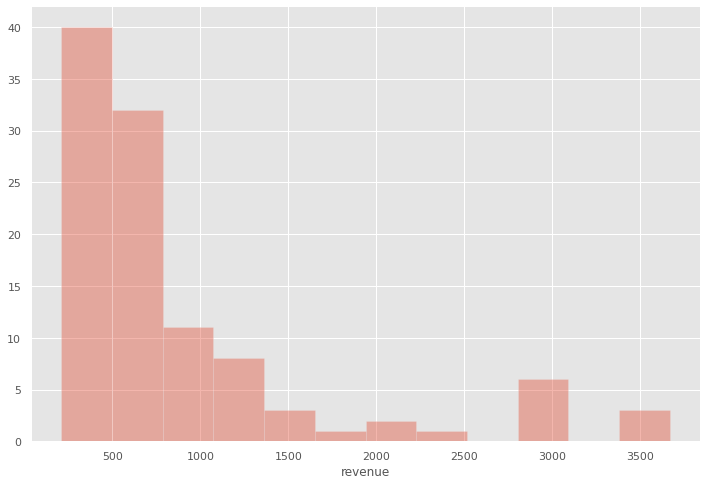

In [12]:
#Видна большая разница между тестовой и контрольной группами (как и в выборке, так и в доходе). Поэтому посмотрим на распределение дохода в группах.
sns.distplot(df_purchases.query('group == "A"').revenue, kde=False)

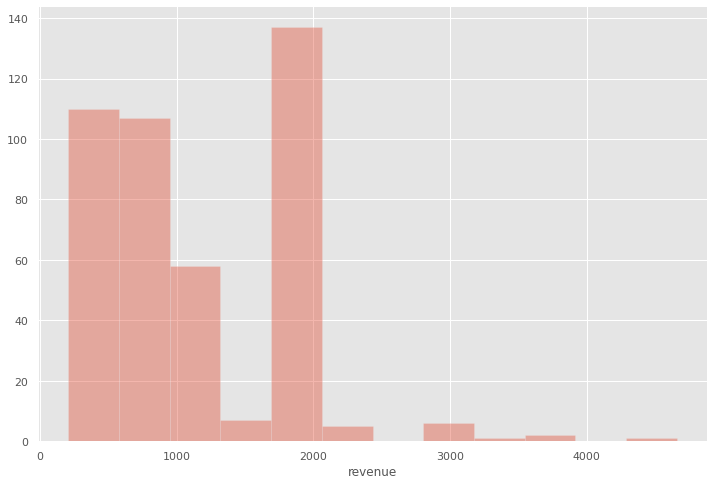

In [13]:
sns.distplot(df_purchases.query('group == "B"').revenue, kde=False)

In [14]:
#Распределения выглядят схожими и несимметричными. В группе В большое скачок дохода в районе 75 перцентиля 
df_purchases.query('group == "A"').revenue.describe().iloc[4:7]

25%     300.5
50%     698.0
75%    1001.0
Name: revenue, dtype: float64

In [15]:
df_purchases.query('group == "B"').revenue.describe().iloc[4:7]

25%     432.0
50%     944.0
75%    1909.0
Name: revenue, dtype: float64

In [16]:
# Сравнивая перцентили можно увидеть увеличение в группе В в 2 и 1,5 раза. 
# Тестовая группа имеет доход выше.

In [17]:
#Проведем А/В тест, чтобы уровнять количество наблюдений (выборки),Student-test и критерии Манна-Уитни  чтобы провести более равный анализ 
#В группе А 107 наблюдений, в группе В 434. Возьмем 107 наблюдений в обеих группах

In [18]:
df_purchases_b=df_purchases.query('group=="B"').sample(n=107)
df_purchases_b

,user_id,revenue,group
447,2503,1912.0,B
293,4979,1910.0,B
321,6816,210.0,B
355,607,300.0,B
145,2754,998.0,B
...,...,...,...
68,2919,700.0,B
405,9126,302.0,B
231,3988,4660.0,B
383,8339,298.0,B


In [19]:
#Выбрав случайные 107 наблюдения, сделаем А/А тест для репрезентативности данны, ипользуя бутстрап.

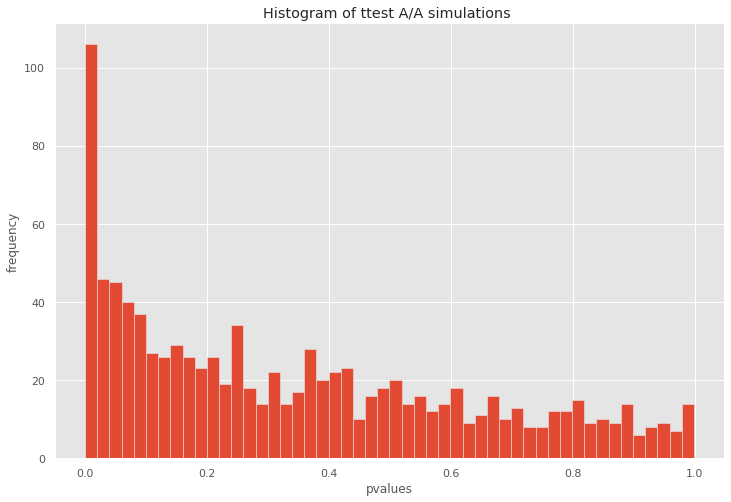

0.177

In [20]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df_2 = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

for i in tqdm(range(simulations)):
    s1 = df_purchases.query('group=="B"').revenue.sample(n_s,replace=True).values#изначальная группа В
    s2 = df_purchases_b.revenue.sample(n_s,replace=True).values # подвыборка из группы В
    res.append(stats.ttest_ind(s1, s2,equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

In [21]:
# Уровень значимости 0.23, различия в 23% случаях. Различия существенны. Посмотрим на результаты Т-теста без бутстрапа
stats.ttest_ind(df_purchases.query('group == "B"').revenue, df_purchases_b.revenue)

Ttest_indResult(statistic=-0.4314071243006949, pvalue=0.6663448641828336)

In [22]:
# Т-тест показал, что подвыборка и изначальные данные одинаковы. Возьмем еще одну подвыборку
df_purchases_с=df_purchases.query('group == "B"').sample(n=107)
df_purchases_с

,user_id,revenue,group
485,9140,1911.0,B
345,77,1911.0,B
254,9100,210.0,B
43,1512,999.0,B
491,5301,298.0,B
...,...,...,...
10,9007,300.0,B
185,4385,1908.0,B
211,414,209.0,B
317,6649,2107.0,B


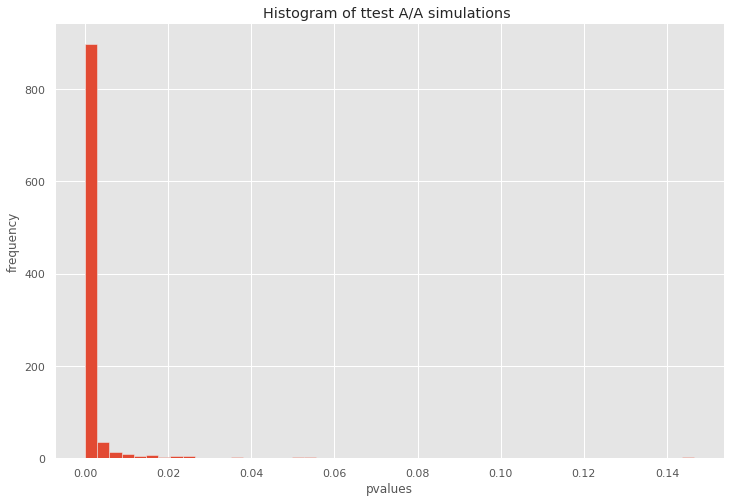

0.984

In [23]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df_2 = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

for i in tqdm(range(simulations)):
    s1 = df_purchases.query('group == "B" and revenue<2500').revenue.sample(n_s,replace=True).values # изначальная группа В
    s2 = df_purchases_с.query('revenue<2500').revenue.sample(n_s,replace=True).values # подвыборка из группы В
    res.append(stats.ttest_ind(s1, s2,equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

In [24]:
# Получаем 0.07 и принимаем. Подвыборка и изначальные данные одинаковы. Делаем А/В тест. Посмотрим распределение

In [25]:
group_a = df_purchases.query('group == "A"').revenue # Перезапищем переменные, а то с названиями беда
group_b = df_purchases_с.revenue

In [26]:
 stats.shapiro(group_a)

(0.7201215028762817, 5.480257090142993e-13)

In [27]:
 stats.shapiro(group_b)

(0.8581608533859253, 1.0439584308130634e-08)

In [28]:
# Распределение не нормальное. Возьмем для удобства логарифм

In [29]:
 stats.shapiro(np.log(group_a))

(0.9208861589431763, 8.361873369722161e-06)

In [30]:
stats.shapiro(np.log(group_b))

(0.864297091960907, 1.8345328811619765e-08)

In [31]:
stats.ttest_ind(np.log(group_a), np.log(group_b))

Ttest_indResult(statistic=-4.031486007124949, pvalue=7.729529777397182e-05)

In [32]:
stats.mannwhitneyu(np.log(group_a), np.log(group_b))

MannwhitneyuResult(statistic=3842.0, pvalue=1.6050878894436044e-05)

In [33]:
# Результаты статистически значимы, p-value много меньше 0.05. Проведем бутстрап с медианой для надежности

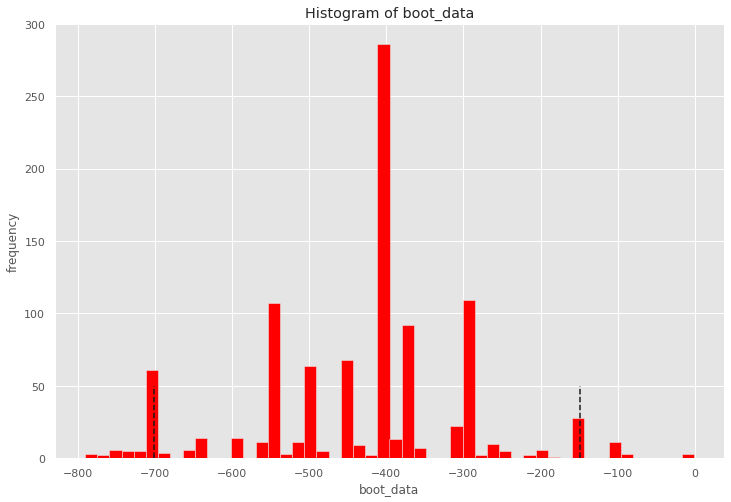

{'boot_data': [-401.0,
  -760.0,
  -400.0,
  -701.0,
  -452.0,
  -401.0,
  -370.0,
  -398.0,
  -451.0,
  -492.0,
  -441.0,
  -149.0,
  -400.0,
  -506.0,
  -400.0,
  -400.0,
  -300.0,
  -400.0,
  -397.0,
  -368.0,
  -502.0,
  -501.0,
  -300.0,
  -550.0,
  -598.0,
  -370.0,
  -400.0,
  -153.0,
  -399.0,
  -367.0,
  -302.0,
  -402.0,
  -451.0,
  -389.0,
  -401.0,
  -301.0,
  -399.0,
  -302.0,
  -398.0,
  -661.0,
  -150.0,
  -400.0,
  -400.0,
  -402.0,
  -689.0,
  -721.0,
  -100.0,
  -301.0,
  -400.0,
  -452.0,
  -370.0,
  -402.0,
  -350.0,
  -400.0,
  -368.0,
  -353.0,
  -503.0,
  -369.0,
  -451.0,
  -453.0,
  -401.0,
  -400.0,
  -501.0,
  -700.0,
  -548.0,
  -259.0,
  -453.0,
  -563.0,
  -501.0,
  -400.0,
  -108.0,
  -399.0,
  -704.0,
  -300.0,
  -368.0,
  -551.0,
  -402.0,
  -491.0,
  -550.0,
  -494.0,
  -401.0,
  -370.0,
  -696.0,
  -351.0,
  -217.0,
  -250.0,
  -412.0,
  -702.0,
  -298.0,
  -94.0,
  -369.0,
  -549.0,
  -300.0,
  -551.0,
  -702.0,
  -451.0,
  -368.0,
  -452.0,
  -256.0

In [34]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)]) # как раз здесь бы отсеклись наблюдения
    boot_data = []                                           # если бы мы не сделали этого сами
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

get_bootstrap(group_a,group_b)

In [35]:
# P-value < 0.05. Отвергаем Ho нулевую гипотезу, различия между группами статистически значимы!

In [36]:
# Найдем факторы за счет которых были получены такие различия.
df = df_purchases.merge(users,how='left')
df

,user_id,revenue,group,country,platform,sex
0,4412,1000.0,A,Russia,android,female
1,9000,701.0,B,NaN,NaN,NaN
2,9001,700.0,B,NaN,NaN,NaN
3,9002,702.0,B,NaN,NaN,NaN
4,5790,1002.0,B,Sweden,android,male
...,...,...,...,...,...,...
536,5648,1908.0,B,Sweden,android,female
537,2277,1912.0,B,Sweden,ios,female
538,5032,1911.0,B,Sweden,ios,male
539,908,1910.0,B,Sweden,android,male


In [37]:
df.isna().sum()

user_id       0
revenue       0
group         0
country     149
platform    149
sex         149
dtype: int64

In [38]:
df.dropna(inplace=True)
df

,user_id,revenue,group,country,platform,sex
0,4412,1000.0,A,Russia,android,female
4,5790,1002.0,B,Sweden,android,male
8,2627,300.0,B,Russia,ios,female
26,7324,1910.0,B,Sweden,android,female
27,7666,701.0,B,Sweden,android,female
...,...,...,...,...,...,...
536,5648,1908.0,B,Sweden,android,female
537,2277,1912.0,B,Sweden,ios,female
538,5032,1911.0,B,Sweden,ios,male
539,908,1910.0,B,Sweden,android,male


In [39]:
df.group.value_counts()

B    314
A     78
Name: group, dtype: int64

In [40]:
df.country.value_counts()

Russia    240
Sweden    152
Name: country, dtype: int64

In [41]:
df.platform.value_counts()

android    208
ios        184
Name: platform, dtype: int64

In [42]:
df.sex.value_counts()

male      201
female    191
Name: sex, dtype: int64

In [43]:
# Сравняем данные по количеству наблюдений, взяв меньшее значение из групп. 

In [44]:
df.query('group == "B"').sample(n=78)

,user_id,revenue,group,country,platform,sex
415,4324,301.0,B,Russia,ios,female
277,2810,210.0,B,Russia,ios,male
366,6554,602.0,B,Sweden,android,female
321,6816,210.0,B,Russia,android,male
131,5182,1910.0,B,Russia,ios,male
...,...,...,...,...,...,...
536,5648,1908.0,B,Sweden,android,female
127,7742,1912.0,B,Sweden,ios,male
336,2498,850.0,B,Sweden,android,female
218,3659,300.0,B,Russia,ios,male


In [45]:
df.query('group == "A"')

,user_id,revenue,group,country,platform,sex
0,4412,1000.0,A,Russia,android,female
31,2619,1840.0,A,Russia,ios,male
41,392,2920.0,A,Sweden,android,male
44,2093,2828.0,A,Sweden,android,male
64,7950,3669.0,A,Russia,ios,male
...,...,...,...,...,...,...
517,6604,1000.0,A,Russia,ios,female
525,1927,1169.0,A,Russia,ios,female
529,4946,299.0,A,Sweden,ios,female
531,1605,498.0,A,Sweden,ios,female


In [46]:
common_df = pd.concat((df.query('group=="A"'), df.query('group=="B"').sample(n=78)))
common_df

,user_id,revenue,group,country,platform,sex
0,4412,1000.0,A,Russia,android,female
31,2619,1840.0,A,Russia,ios,male
41,392,2920.0,A,Sweden,android,male
44,2093,2828.0,A,Sweden,android,male
64,7950,3669.0,A,Russia,ios,male
...,...,...,...,...,...,...
131,5182,1910.0,B,Russia,ios,male
170,7886,881.0,B,Russia,android,male
392,4784,209.0,B,Russia,ios,male
388,4025,300.0,B,Sweden,android,male


In [47]:
group_a = common_df.query('group == "A"')
group_a

,user_id,revenue,group,country,platform,sex
0,4412,1000.0,A,Russia,android,female
31,2619,1840.0,A,Russia,ios,male
41,392,2920.0,A,Sweden,android,male
44,2093,2828.0,A,Sweden,android,male
64,7950,3669.0,A,Russia,ios,male
...,...,...,...,...,...,...
517,6604,1000.0,A,Russia,ios,female
525,1927,1169.0,A,Russia,ios,female
529,4946,299.0,A,Sweden,ios,female
531,1605,498.0,A,Sweden,ios,female


In [48]:
# Используем многофакторный дисперсионный анализ
model= smf.ols(formula='revenue~country+platform+sex+country:platform+country:sex+platform:sex', data=group_a).fit()
anova_table = anova_lm(model,typ=2)
print(anova_table)

                        sum_sq    df         F    PR(>F)
country           7.605312e+05   1.0  0.905343  0.344581
platform          1.711599e+05   1.0  0.203750  0.653086
sex               1.105386e+05   1.0  0.131586  0.717871
country:platform  1.595564e+06   1.0  1.899373  0.172476
country:sex       7.747816e+05   1.0  0.922307  0.340129
platform:sex      4.827818e+05   1.0  0.574708  0.450903
Residual          5.964337e+07  71.0       NaN       NaN


In [49]:
# Комбинация факторов страна:платформа (0.17) самая значимая. Вообще все факторы больше уровня значимости (0.05)
# Это говорит нам, что ни один из факторов или их комбинации не влияют на доход

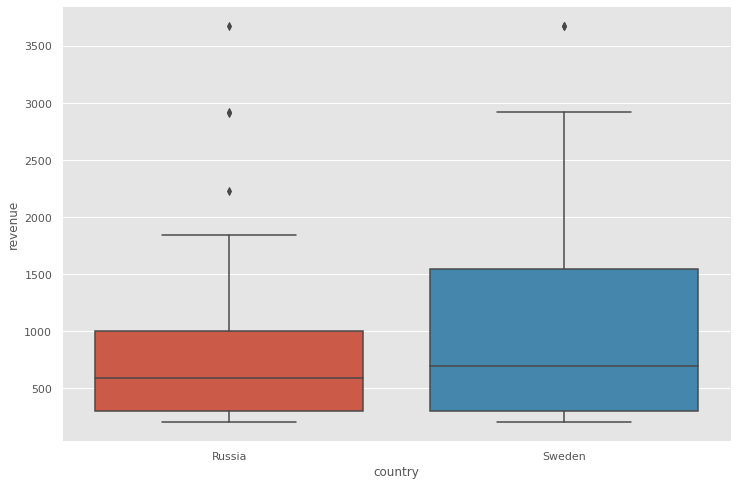

In [50]:
sns.boxplot(x='country',y='revenue', data=group_a) # доход в Швеции выше

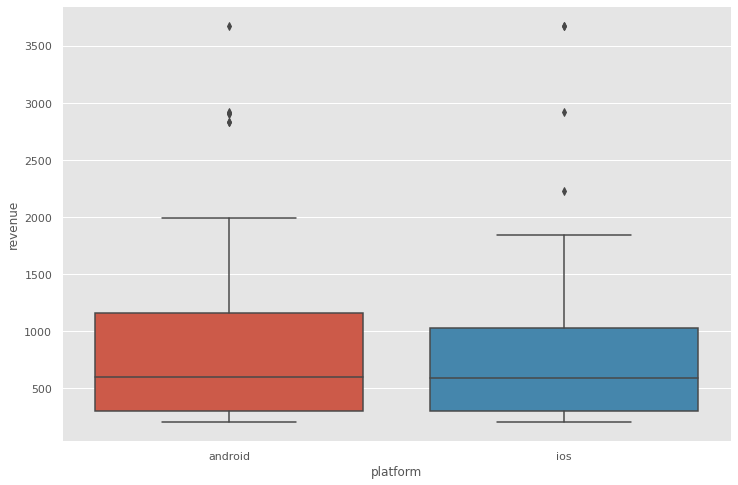

In [51]:
sns.boxplot(x='platform',y='revenue', data=group_a) # Андроид чуть выше по доходу

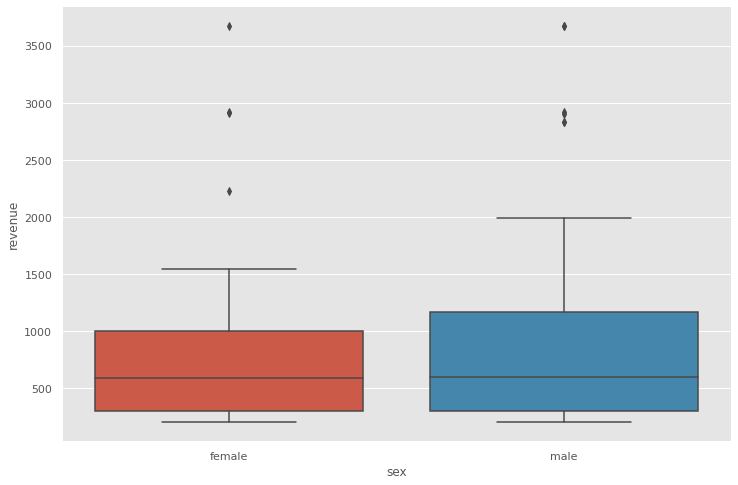

In [52]:
 sns.boxplot(x='sex',y='revenue', data=group_a) #У мужчин немного выше квантили

In [53]:
# Больше всего дохода приносят мужчины из Швеции с платформы Андроид. Все это была группа А.

In [54]:
# Теперь рассмотрим группу В
group_b = common_df.query('group == "B"')
group_b 

,user_id,revenue,group,country,platform,sex
160,4571,1909.0,B,Russia,android,male
315,524,300.0,B,Russia,android,male
391,1162,409.0,B,Russia,android,male
156,7185,1909.0,B,Sweden,android,male
373,5593,1349.0,B,Russia,ios,male
...,...,...,...,...,...,...
131,5182,1910.0,B,Russia,ios,male
170,7886,881.0,B,Russia,android,male
392,4784,209.0,B,Russia,ios,male
388,4025,300.0,B,Sweden,android,male


In [55]:
model=smf.ols(formula ='revenue~country+platform+sex+country:platform+country:sex+platform:sex',data = group_b).fit()
anova_table = anova_lm(model,typ=2)
print(anova_table)

                        sum_sq    df         F    PR(>F)
country           1.564888e+05   1.0  0.244168  0.622737
platform          2.742058e+04   1.0  0.042784  0.836724
sex               1.292159e+06   1.0  2.016142  0.160010
country:platform  8.429723e+05   1.0  1.315281  0.255291
country:sex       3.877468e+04   1.0  0.060500  0.806417
platform:sex      1.337767e+05   1.0  0.208730  0.649159
Residual          4.550437e+07  71.0       NaN       NaN


In [56]:
# Результат похож с группой В. Выпадает только платформа 
group_b.query('platform=="android"').revenue.describe()

count      46.000000
mean     1168.347826
std       704.784576
min       208.000000
25%       454.000000
50%      1000.500000
75%      1909.000000
max      2110.000000
Name: revenue, dtype: float64

In [57]:
group_b.query('platform=="ios"').revenue.describe()

count      32.000000
mean     1173.312500
std       908.611292
min       209.000000
25%       381.500000
50%       879.000000
75%      1910.000000
max      3670.000000
Name: revenue, dtype: float64

In [58]:
 # Большая разница на 25 перцентиле и медиана больше в 2 раза

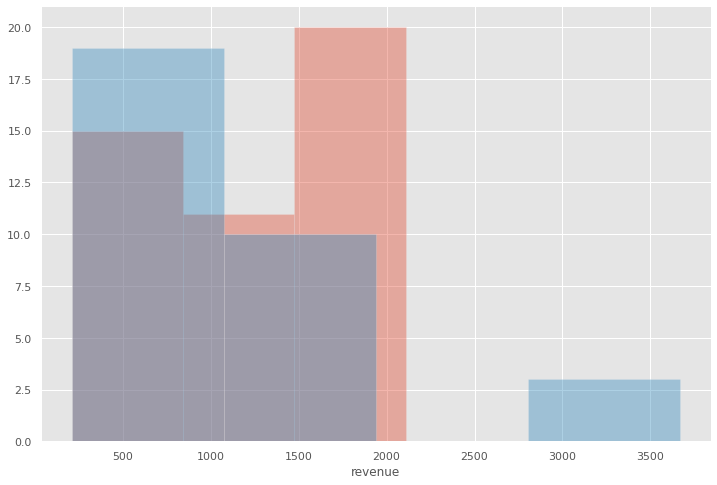

In [59]:
sns.distplot(group_b.query('platform=="android"').revenue,kde=False)
sns.distplot(group_b.query('platform=="ios"').revenue,kde=False)

In [60]:
# Доход на iOS выше. Рассмотрим данные подробнее

In [61]:
x = df.query('platform == "android"').revenue
x

0      1000.0
4      1002.0
26     1910.0
27      701.0
34     1912.0
        ...  
533    2110.0
535    1909.0
536    1908.0
539    1910.0
540    1910.0
Name: revenue, Length: 208, dtype: float64

In [62]:
y= df.query('platform == "ios"').revenue
y

8       300.0
29      208.0
30      408.0
31     1840.0
33     1910.0
        ...  
528     301.0
529     299.0
531     498.0
537    1912.0
538    1911.0
Name: revenue, Length: 184, dtype: float64

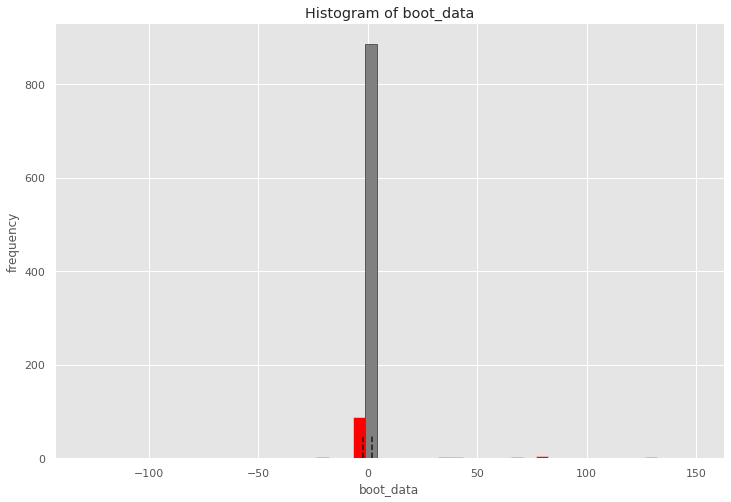

{'boot_data': [0.0,
  -1.0,
  0.0,
  1.0,
  1.0,
  -97.5,
  1.0,
  0.5,
  0.0,
  0.5,
  -1.0,
  1.0,
  0.0,
  -1.0,
  -1.0,
  75.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  -1.0,
  0.0,
  3.0,
  -1.0,
  -1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  -1.0,
  0.0,
  0.5,
  1.0,
  -1.0,
  -1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  -1.0,
  1.0,
  -1.0,
  0.0,
  -1.0,
  2.0,
  -0.5,
  -1.0,
  -1.0,
  -1.0,
  0.0,
  1.0,
  -1.5,
  0.0,
  -2.0,
  0.0,
  0.0,
  -1.0,
  -2.0,
  0.0,
  -1.0,
  0.0,
  -2.0,
  0.0,
  0.0,
  0.0,
  -1.5,
  -2.0,
  -18.0,
  -1.0,
  -1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  2.0,
  0.0,
  -24.5,
  -1.0,
  -2.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  80.0,
  1.0,
  0.0,
  -0.5,
  2.0,
  -2.0,
  0.0,
  -2.0,
  -1.0,
  -0.5,
  1.0,
  -2.0,
  0.0,
  1.0,
  1.0,
  -1.0,
  2.5,
  0.0,
  0.5,
  0.0,
  1.0,
  2.0,
  0.0,
  2.0,
  0.0,
  0.0,
  1.0,
  -1.0,
  0.0,


In [63]:
get_bootstrap(x,y)

In [64]:
stats.ttest_ind(x,y)

Ttest_indResult(statistic=-0.2585537237021608, pvalue=0.7961159899615824)

In [65]:
# Группы практически одинаковы 

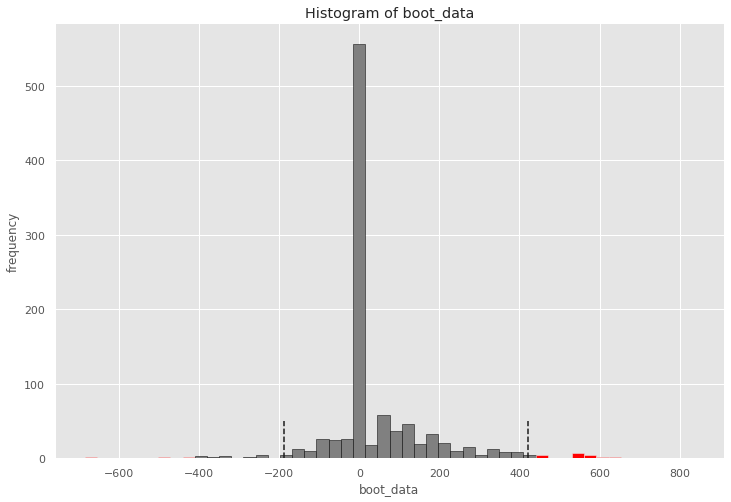

{'boot_data': [-1.5,
  -90.0,
  -59.0,
  117.0,
  0.0,
  1.5,
  0.0,
  -1.0,
  -1.5,
  -1.5,
  1.5,
  -1.0,
  115.5,
  -1.0,
  -10.0,
  2.0,
  -2.0,
  402.5,
  -0.5,
  45.0,
  44.0,
  -61.0,
  -1.0,
  0.0,
  0.0,
  224.0,
  -133.5,
  -2.0,
  -2.5,
  -2.0,
  54.0,
  74.5,
  -16.5,
  -16.0,
  1.5,
  -37.5,
  220.5,
  54.5,
  -1.5,
  0.0,
  244.5,
  3.0,
  -1.0,
  409.5,
  1.0,
  0.0,
  214.5,
  44.5,
  -1.5,
  -0.5,
  -99.0,
  -68.0,
  1.0,
  -76.5,
  119.5,
  230.0,
  63.0,
  -0.5,
  0.0,
  -0.5,
  -2.0,
  128.5,
  -1.0,
  -367.5,
  -2.5,
  -1.0,
  -1.5,
  1.5,
  0.0,
  -2.0,
  56.0,
  -1.0,
  -395.0,
  -0.5,
  -0.5,
  -1.5,
  425.5,
  -3.0,
  2.0,
  554.0,
  -118.5,
  2.5,
  1.5,
  175.5,
  0.0,
  -2.5,
  1.0,
  380.5,
  1.0,
  -1.0,
  -0.5,
  1.5,
  -1.0,
  151.5,
  -305.5,
  -1.0,
  -2.5,
  321.5,
  -0.5,
  -1.0,
  370.5,
  -55.0,
  45.5,
  371.0,
  45.5,
  -421.5,
  -75.0,
  1.0,
  -1.0,
  -2.0,
  -101.0,
  407.0,
  4.0,
  -1.0,
  76.0,
  1.5,
  -249.0,
  45.5,
  0.0,
  -149.5,
  0.

In [66]:
get_bootstrap(group_b.query('platform=="android"').revenue,group_b.query('platform=="ios"').revenue)

In [67]:
stats.ttest_ind(group_b.query('platform=="android"').revenue,group_b.query('platform=="ios"').revenue)

Ttest_indResult(statistic=-0.02715384010434844, pvalue=0.9784082079160836)

Т.к. на iOS значения разбросанней, то мы получаем на бутстрапе значение в 0.46. А Т-тест выдал стат значимость.
Группы идентичны. Различия связаны именно со случайностью подвыборки

Узнаем, значимы ли различия, полученные в ходе эсксперимента в разрезе факторов
Используем бутстрап на медиане и Т-тест как дополнение

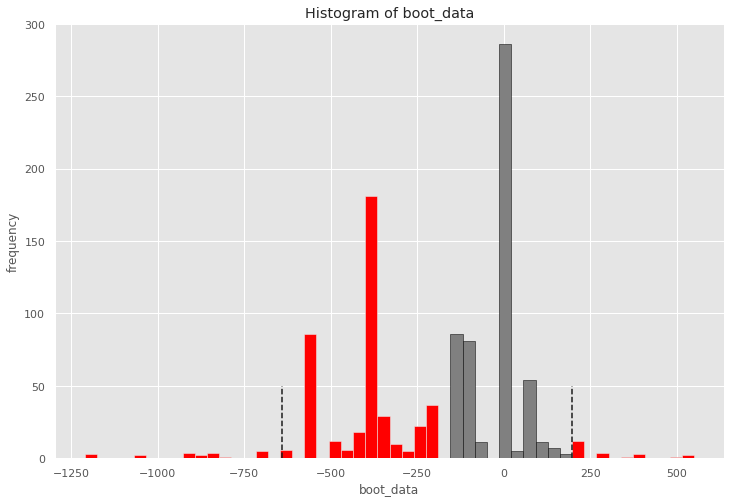

{'boot_data': [1.0,
  1.0,
  -92.0,
  -372.0,
  -1.0,
  -71.0,
  0.0,
  -366.0,
  -250.0,
  198.0,
  2.0,
  0.0,
  90.0,
  0.0,
  -550.0,
  -1.0,
  -221.0,
  92.0,
  -2.0,
  -400.0,
  -397.0,
  -369.0,
  -1.0,
  -398.0,
  -550.0,
  153.0,
  152.0,
  2.0,
  -642.0,
  -203.0,
  -2.0,
  46.0,
  -2.0,
  -369.0,
  -352.0,
  -103.0,
  1.0,
  -103.0,
  -200.0,
  -1.0,
  -93.0,
  -147.0,
  288.0,
  0.0,
  -148.0,
  -148.0,
  0.0,
  1.0,
  1.0,
  90.0,
  -91.0,
  -350.0,
  549.0,
  -549.0,
  -372.0,
  0.0,
  -402.0,
  -396.0,
  -2.0,
  0.0,
  -503.0,
  -911.0,
  -351.0,
  -397.0,
  -1.0,
  89.0,
  -1.0,
  -92.0,
  -2.0,
  -1.0,
  197.0,
  0.0,
  1.0,
  81.0,
  -702.0,
  -371.0,
  0.0,
  -453.0,
  -398.0,
  -368.0,
  -397.0,
  -1058.0,
  -550.0,
  -101.0,
  -148.0,
  -1.0,
  -92.0,
  -401.0,
  -3.0,
  0.0,
  -549.0,
  -549.0,
  -222.0,
  -398.0,
  -2.0,
  0.0,
  -260.0,
  149.0,
  -550.0,
  -148.0,
  2.0,
  -151.0,
  -369.0,
  -1.0,
  -94.0,
  -561.0,
  -371.0,
  1.0,
  -250.0,
  -130.0,
  -203.

In [68]:
get_bootstrap(group_a.query('country == "Sweden"').revenue, group_b.query('country == "Sweden"').revenue)

In [69]:
stats.ttest_ind(group_a.query('country == "Sweden"').revenue, group_b.query('country == "Sweden"').revenue)

Ttest_indResult(statistic=-0.549944114352684, pvalue=0.5843657906365398)

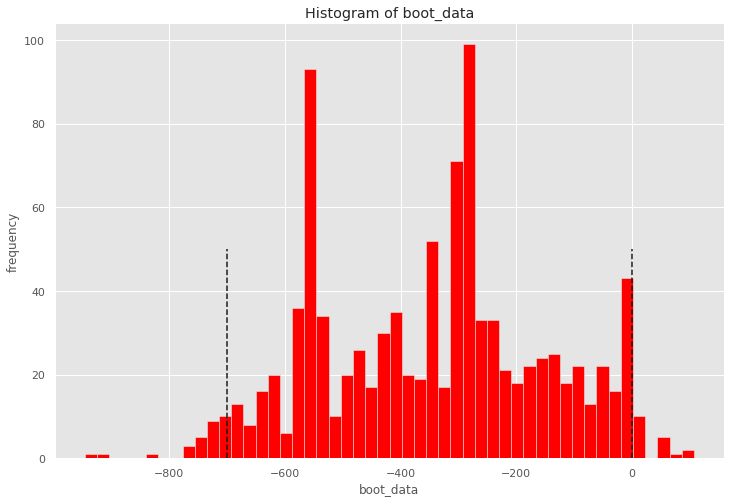

{'boot_data': [-258.0,
  -155.5,
  -199.0,
  -420.0,
  -91.5,
  -635.5,
  -285.0,
  -233.5,
  -553.0,
  -217.0,
  -283.5,
  -550.5,
  -555.0,
  -204.0,
  -298.0,
  -552.0,
  -582.0,
  -543.0,
  -527.0,
  -89.0,
  -747.5,
  -201.0,
  -289.5,
  -134.0,
  -171.0,
  -419.5,
  -275.5,
  -579.0,
  -338.0,
  -396.0,
  -345.5,
  -251.0,
  -654.0,
  75.5,
  -527.5,
  -289.5,
  -274.5,
  -304.5,
  -585.5,
  -555.5,
  -282.0,
  -399.0,
  -296.5,
  -639.5,
  -288.5,
  -378.5,
  -130.0,
  -620.0,
  -555.5,
  -179.5,
  -668.0,
  -453.5,
  -241.0,
  -355.0,
  -425.5,
  -294.5,
  -0.5,
  -444.5,
  -349.0,
  -81.0,
  -394.0,
  -1.0,
  -1.5,
  -720.0,
  -371.5,
  -283.5,
  -81.0,
  -698.5,
  -730.0,
  -297.5,
  -100.5,
  -720.0,
  -344.5,
  -571.5,
  -351.0,
  -343.0,
  -59.5,
  -336.0,
  -415.5,
  -12.0,
  -144.5,
  -155.5,
  -368.5,
  -328.5,
  -275.0,
  -1.5,
  -251.0,
  -290.0,
  -639.0,
  -272.5,
  -288.5,
  -445.5,
  -201.5,
  -238.0,
  -294.0,
  -570.5,
  -554.5,
  15.0,
  -209.5,
  -594.0,
  -99

In [70]:
 get_bootstrap(group_a.query('country == "Russia"').revenue, group_b.query('country == "Russia"').revenue)

In [71]:
stats.ttest_ind(group_a.query('country == "Russia"').revenue, group_b.query('country == "Russia"').revenue)

Ttest_indResult(statistic=-1.964643610907836, pvalue=0.05250612954854279)

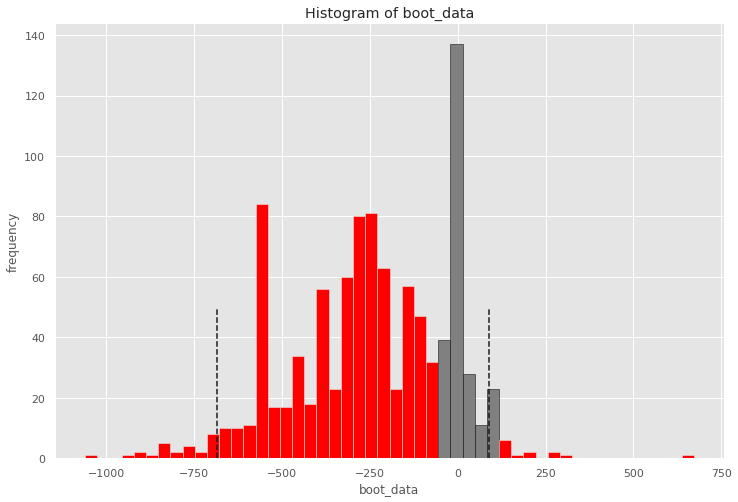

{'boot_data': [-464.0,
  281.0,
  -437.5,
  -199.5,
  -1.5,
  -255.5,
  -125.0,
  -131.0,
  -242.5,
  -439.5,
  -833.0,
  -255.0,
  -46.0,
  -199.0,
  -328.0,
  -505.5,
  -274.5,
  -177.5,
  -253.5,
  5.5,
  -335.0,
  -75.5,
  -145.0,
  -47.5,
  -671.0,
  -46.5,
  -641.0,
  -1.0,
  -150.0,
  -329.0,
  53.5,
  -333.0,
  2.0,
  -327.5,
  -460.0,
  -150.5,
  -258.5,
  -228.0,
  -165.5,
  -249.5,
  -368.0,
  -385.5,
  -48.0,
  -0.5,
  -309.0,
  -106.0,
  2.0,
  1.5,
  -148.0,
  -309.0,
  46.0,
  -221.5,
  -611.0,
  -281.5,
  -0.5,
  -437.0,
  -549.5,
  -269.0,
  -385.0,
  -1.0,
  -93.0,
  -327.5,
  -122.5,
  -255.5,
  -270.5,
  -777.5,
  -71.0,
  -176.0,
  -237.0,
  -100.0,
  -500.0,
  -669.5,
  -340.5,
  -574.0,
  -198.5,
  -100.5,
  -596.0,
  43.5,
  -225.5,
  -480.0,
  -151.5,
  -204.0,
  -201.0,
  -0.5,
  -222.5,
  -367.5,
  -48.0,
  -527.5,
  -105.0,
  -121.5,
  -566.0,
  -221.5,
  -458.0,
  -129.0,
  -279.5,
  88.0,
  -389.0,
  -312.5,
  -597.0,
  -120.0,
  -334.0,
  -368.5,
  -548.0

In [72]:
get_bootstrap(group_a.query('platform == "android"').revenue, group_b.query('platform == "android"').revenue)

In [73]:
stats.ttest_ind(group_a.query('platform == "android"').revenue, group_b.query('platform == "android"').revenue)

Ttest_indResult(statistic=-0.8041047343581408, pvalue=0.42363360599148114)

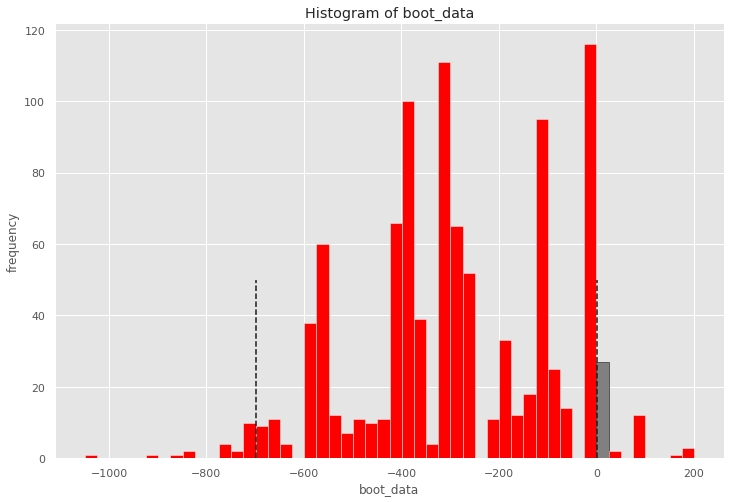

{'boot_data': [-538.0,
  -441.0,
  -91.0,
  -579.0,
  -398.0,
  -553.0,
  -501.0,
  -650.0,
  -447.0,
  -111.0,
  -129.0,
  -1.0,
  -108.0,
  -577.0,
  -352.0,
  -698.0,
  -111.0,
  -398.0,
  -252.0,
  0.0,
  -281.0,
  -261.0,
  -150.0,
  -149.0,
  -397.0,
  -394.0,
  -379.0,
  0.0,
  -301.0,
  -288.0,
  -400.0,
  -302.0,
  -109.0,
  -154.0,
  -402.0,
  -8.0,
  -109.0,
  -303.0,
  -304.0,
  -279.0,
  -399.0,
  -400.0,
  -307.0,
  -401.0,
  -301.0,
  -2.0,
  -303.0,
  0.0,
  -108.0,
  -401.0,
  -102.0,
  -298.0,
  -749.0,
  -1.0,
  -399.0,
  -387.0,
  -2.0,
  1.0,
  -580.0,
  -288.0,
  -398.0,
  -551.0,
  -352.0,
  -353.0,
  -651.0,
  -111.0,
  0.0,
  -307.0,
  -441.0,
  -380.0,
  -107.0,
  -252.0,
  -3.0,
  -2.0,
  -700.0,
  -251.0,
  -107.0,
  -387.0,
  -180.0,
  0.0,
  -352.0,
  -2.0,
  -397.0,
  -398.0,
  -68.0,
  -108.0,
  -176.0,
  -301.0,
  -148.0,
  -1.0,
  -397.0,
  -306.0,
  -698.0,
  -307.0,
  -308.0,
  -301.0,
  -261.0,
  -551.0,
  -401.0,
  -401.0,
  -306.0,
  -759.0,
  -39

In [74]:
get_bootstrap(group_a.query('platform == "ios"').revenue, group_b.query('platform == "ios"').revenue)

In [75]:
stats.ttest_ind(group_a.query('platform == "ios"').revenue, group_b.query('platform == "ios"').revenue)

Ttest_indResult(statistic=-1.4468204070816786, pvalue=0.152475071707718)

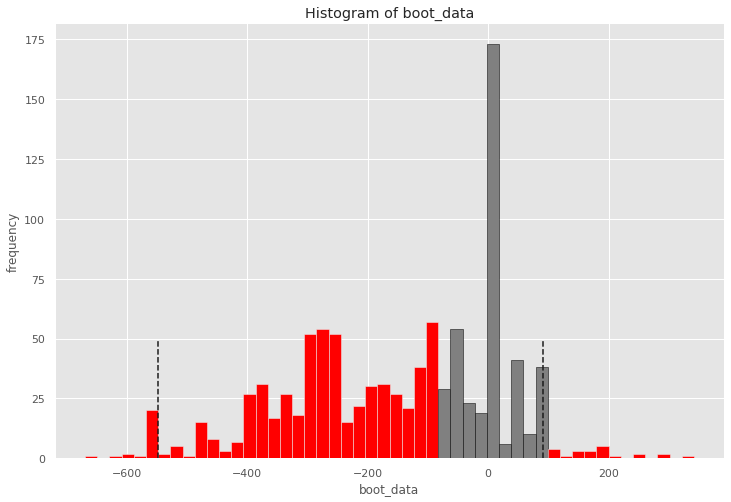

{'boot_data': [0.5,
  -104.5,
  -35.5,
  -300.5,
  -178.5,
  -242.0,
  -7.5,
  -155.5,
  90.0,
  -334.5,
  -1.0,
  42.0,
  -62.0,
  -326.0,
  -104.5,
  5.5,
  0.0,
  -471.0,
  -186.5,
  -256.5,
  -93.0,
  -1.0,
  -91.0,
  -91.0,
  82.5,
  -370.5,
  45.5,
  -264.5,
  -259.5,
  30.5,
  -335.0,
  -91.0,
  -386.0,
  -127.5,
  39.5,
  -270.0,
  -295.5,
  119.0,
  -46.5,
  -80.5,
  -46.5,
  -105.5,
  15.0,
  -198.0,
  2.0,
  -55.5,
  1.5,
  151.0,
  -259.0,
  -150.0,
  -1.0,
  -109.0,
  -46.5,
  85.5,
  -358.5,
  -398.0,
  -154.0,
  -274.0,
  -302.0,
  -91.0,
  85.0,
  -1.0,
  -1.0,
  -124.5,
  14.0,
  -326.0,
  1.0,
  -161.0,
  -91.0,
  -134.5,
  -48.0,
  -369.5,
  -54.5,
  -351.5,
  -265.0,
  -225.0,
  -56.5,
  -269.5,
  -196.0,
  89.0,
  -198.5,
  38.0,
  -56.5,
  -284.5,
  46.0,
  0.0,
  -479.0,
  59.0,
  -250.5,
  -36.5,
  -465.5,
  5.5,
  -521.0,
  -407.0,
  86.0,
  -254.5,
  -171.5,
  -669.5,
  -288.5,
  -55.5,
  45.5,
  -124.0,
  -259.5,
  -93.0,
  -300.0,
  -269.5,
  -35.5,
  -255.5

In [76]:
get_bootstrap(group_a.query('sex == "male"').revenue, group_b.query('sex == "male"').revenue)

In [77]:
stats.ttest_ind(group_a.query('sex == "male"').revenue, group_b.query('sex == "male"').revenue)

Ttest_indResult(statistic=-0.22523401535010057, pvalue=0.8223378562983255)

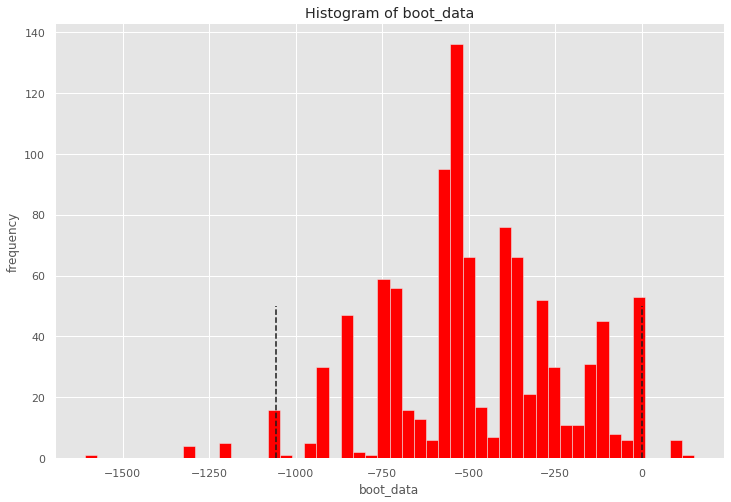

{'boot_data': [-388.0,
  -550.0,
  -550.0,
  -689.0,
  -739.0,
  -470.0,
  -742.0,
  -507.0,
  -556.0,
  -851.0,
  -550.0,
  -741.0,
  -152.0,
  -742.0,
  -366.0,
  -721.0,
  -549.0,
  -699.0,
  0.0,
  -398.0,
  -108.0,
  -552.0,
  -298.0,
  -582.0,
  -507.0,
  -851.0,
  -151.0,
  -581.0,
  -399.0,
  -107.0,
  -721.0,
  -106.0,
  -698.0,
  -548.0,
  -309.0,
  -506.0,
  -366.0,
  -506.0,
  -549.0,
  -352.0,
  -400.0,
  -688.0,
  -550.0,
  -551.0,
  -3.0,
  -507.0,
  -299.0,
  -450.0,
  -749.0,
  -257.0,
  -940.0,
  -409.0,
  -352.0,
  -453.0,
  -580.0,
  -552.0,
  -257.0,
  -551.0,
  -508.0,
  -129.0,
  -307.0,
  -909.0,
  -261.0,
  -291.0,
  -580.0,
  90.0,
  -300.0,
  -581.0,
  -368.0,
  -556.0,
  -760.0,
  -18.0,
  -550.0,
  -701.0,
  -309.0,
  -108.0,
  -549.0,
  -1059.0,
  -851.0,
  89.0,
  -261.0,
  -152.0,
  -697.0,
  -701.0,
  -700.0,
  -560.0,
  -910.0,
  -506.0,
  -1057.0,
  -308.0,
  -306.0,
  -850.0,
  -2.0,
  -550.0,
  -549.0,
  -368.0,
  -908.0,
  -368.0,
  -451.0,
  -506.

In [78]:
get_bootstrap(group_a.query('sex == "female"').revenue, group_b.query('sex == "female"').revenue)

In [79]:
stats.ttest_ind(group_a.query('sex == "female"').revenue, group_b.query('sex == "female"').revenue)

Ttest_indResult(statistic=-2.2483148846173315, pvalue=0.027850466815385205)

Такие категории как пол (женщины), платформа (iOS), страна (Россия) оказались статически значимыми, которые показали доход в группе В выше, вопрос на сколько % он вырос?

In [80]:
a = group_a.query('country == "Russia"').revenue.describe()
b = group_b.query('country == "Russia"').revenue.describe()
diff = round((b/a)*100-100,2)
diff

count    16.28
mean     38.34
std      -4.04
min       0.48
25%      51.33
50%      59.24
75%      90.90
max       0.03
Name: revenue, dtype: float64

In [82]:
a = group_a.query('sex == "female"').revenue.describe()
b = group_b.query('sex == "female"').revenue.describe()
diff = round((b/a)*100-100,2)
diff

count   -13.51
mean     54.61
std      10.51
min       0.48
25%      85.13
50%      94.92
75%      91.00
max       0.00
Name: revenue, dtype: float64

In [81]:
a = group_a.query('platform == "ios"').revenue.describe()
b = group_b.query('platform == "ios"').revenue.describe()
diff = round((b/a)*100-100,2)
diff

count   -17.95
mean     35.78
std       2.60
min       0.48
25%      27.17
50%      48.98
75%      86.43
max       0.00
Name: revenue, dtype: float64

In [90]:
# Посмотрим метрики для наших данных

In [85]:
# Посчитаем ARPU средний доход с клиента
ARPU_group_a = round(df_purchases.query('group == "A"').revenue.sum()/df_purchases.query('group == "A"').user_id.nunique(),1)
ARPU_group_a

870.7

In [86]:
ARPU_group_b = round(df_purchases.query('group == "B"').revenue.sum()/df_purchases.query('group == "B"').user_id.nunique(),1)
ARPU_group_b

1118.8

In [89]:
print(round((ARPU_group_b/ARPU_group_a*100)-100,2),'%')
# Доход увеличился на 28.49%

28.49 %


In [91]:
# Посчитаем конверсию
conversion=users.merge(groups,how='left')
conversion.head()   # Объеденив, мы оставим только тех, кто зашел в приложение во время эксперимента

,user_id,country,platform,sex,group
0,8029,Russia,ios,male,B
1,1735,Sweden,ios,male,B
2,7697,Russia,android,male,B
3,1421,Sweden,android,female,B
4,1704,Russia,ios,male,B


In [92]:
conversion.shape

(8341, 5)

In [93]:
df_purchases.shape

(541, 3)

In [94]:
conversion.query('group == "A"').shape[0]

1538

In [95]:
conversion.query('group == "B"').shape[0]

6803

In [96]:
df_purchases.query('group == "A"').shape[0]

107

In [97]:
df_purchases.query('group == "B"').shape[0]

434

In [98]:
conversion_group_a = df_purchases.query('group == "A"').shape[0]/conversion.query('group == "A"').shape[0]
round(conversion_group_a,2)

0.07

In [99]:
conversion_group_b = df_purchases.query('group == "B"').shape[0]/conversion.query('group == "B"').shape[0]
round(conversion_group_b,2)

0.06

In [100]:
print((conversion_group_b/conversion_group_a*100)-100,'%') # Конверсия упала на 8.3%

-8.301587672288619 %


ARPU увеличился на 28.49%, конверсия уменьшилась на 8.3%, что показывает снижение количества покупок, совершенные пользователями. ПОльзователи, совершившие покупки, принесли доход на 30% больше

Мы принимаем данную фичу, и можно ее выпускать на рынок. Тесты показали увеличение дохода. 

Метрики показали, что увеличение ARPU на 28.49% покрывает снижение конверсии в 8.3%.  

Задание 2

Для оценки вовлеченности пользователей поделим метрики на дашборде на несколько типов:

1. Метрики, оценивающие вовлеченность в продукт. 

Retention rate - коэффициент удержания пользователей
MAU - количество активных пользователей в месяц
Churn rate - коэффициент оттока пользователей

2. Метрики вида использования продукта

Key user actions per session - количество ключевых действий за сессию
Sessions per user - количество сессий пользователя

3. Метрики монетизации 

ARPU - средняя прибыль от одного пользователя за определённый срок
ARPPU - средняя прибыль от одного платящего пользователя за определённый срок
LTV - сколько денег приносит пользователь за определенное время
CTR, CPC - для оценки со встроенной рекламой в продукте
Customer acquisition cost - стоимость привлечения клиента

В дашборд я бы хотел вывести следующие метрики: 
Retention rate - чтобы знать насколько хорошо мы удерживаем пользователей
ARPU, ARPPU - знать доход от пользователей
Key user actions per session - чтобы знать как частота совершается нужное для нас действие (покупка)
Customer acquisition cost - чтобы знать, сколько нам обходится реклама и насколько она эффективна.